In [1]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [2]:
#imports

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time

In [3]:
#imports from object_detection_api

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [4]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [5]:
#function for loading model

def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [6]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [7]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('models/research/object_detection/test_images/image1.jpg'),
 WindowsPath('models/research/object_detection/test_images/image2.jpg')]

In [8]:
#loading ssd_mobilenet model for more speed

model_name = 'ssd_mobilenet_v1_coco_2018_01_28'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [54]:
model_name1 = 'faster_rcnn_inception_v2_coco_2018_01_28'
detection_model1 = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
#calculating area of the bounding boxes

def area(cord1):
    y11,x11,y12,x12 = cord1[0],cord1[1],cord1[2],cord1[3]
    area1 = float(abs(y11-y12)*abs(x11-x12))
    return area1
area([1,2,3,4])

4.0

In [10]:
#sorting the bounding boxes with the corresponding x coordinates to find distance between adjacent people

def sort(arr):
    ar = []
    lent = arr.shape[0]
    for i in range(lent):
        ar.append(arr[i])
    for i in range(0,lent-1):
        for j in range(i+1,lent):
            if ar[i][1] > ar[j][1]:
                temp = ar[i]
                ar[i] = ar[j]
                ar[j] = temp
    return ar

In [11]:
#calculating distance between people in picture

def dist_bw1(cord1,cord2,image):
    s1 , s2 = image.shape[0] , image.shape[1]
    y11,x11,y12,x12 = cord1[0],cord1[1],cord1[2],cord1[3]
    y21,x21,y22,x22 = cord2[0],cord2[1],cord2[2],cord2[3]
    '''X = int(x12*s2)
    Y = int(d1*y12)
    
    X1 = int(x11*s2)
    Y1 = int(s1*y11)'''
    #image=cv2.line(image,(X1,Y1),(X,Y),(0,255,0),9)
    len1 = abs(y11-y12)
    len2= abs(y21-y22)
    c11,c12 = float((y11+y12)/2),float((x11+x12)/2)
    c21,c22 = float((y21+y22)/2),float((x21+x22)/2)
    #d3 = (((c12-c22)**(2) + (c11-c21)**(2))**(0.5))
    d1 = 24.161*(len1**2) - 31.2*(len1) + 12.039
    d2 = 24.161*(len2**2) - 31.2*(len2) + 12.039
    d3 = (1/4360)*(c22-c12)
    dmax = max(d1,d2)
    dmin = min(d1,d2)
    dmax2 = dmax - dmin
    dist = (d3**2 + dmax2*2)**(0.5)
    #d21 = (abs(min(d1,d2)**2 - d3**2))**(0.5)
    #d22 = abs(d21-max(d2,d1))
    #dist = (d3**2 + d22**2)**(0.5)
    c11 = int(s1*c11)
    c21 = int(s1*c21)
    c12 = int(s2*c12)
    c22 = int(s2*c22)
    #image=cv2.line(image,(0,0),(c22,c21),(0,255,0),9)
    print("d1",d1,"\n") #int((c11+c21)/2),int((c12+c22)/2)
    print("d2",d2,"\n")
    print("d3",c22-c12)
    print("\ndist",dist)
    font = cv2.FONT_HERSHEY_SIMPLEX
    s = round(dist,2)
    image=cv2.line(image,(c12,c11),(c22,c21),(0,255,0),5)
    cv2.putText(image,str(s),(int((c12+c22)/2)-20,int((c11+c21)/2)), font, 1, (250,250,250), 2, cv2.LINE_AA)
    #image=cv2.line(image,(c12,c11),(c22,c11),(255,0,0),9)
    

    return dist


In [12]:
#appeding all calculated distances

def social_dist2(arr,image):
    sorta = sort(arr)
    dis = []
    #print(sorta)
    lent = arr.shape[0]
    for i in range(0,lent):
        if i+1 < lent:
            d  =dist_bw1(sorta[i],sorta[i+1],image)
            dis.append(d)
            
    return dis


In [13]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]
    output_dict = model(input_tensor)
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [15]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))
	faceNet.setInput(blob)
	detections = faceNet.forward()
	faces = []
	locs = []
	preds = []
	for i in range(0, detections.shape[2]):
		confidence = detections[0, 0, i, 2]
		if confidence > 0.5:
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			face = np.expand_dims(face, axis=0)
			faces.append(face)
			locs.append((startX, startY, endX, endY))
	if len(faces) > 0:
		preds = maskNet.predict(faces)
	return (locs, preds)

In [21]:
#loading model and weights for face recognition model

faceNet = cv2.dnn.readNet("C:\\Users\\Sivaraman\\Desktop\\Py_projects\\face-mask-detector\\face_detector\\deploy.prototxt",
                          "C:\\Users\\Sivaraman\\Desktop\\Py_projects\\face-mask-detector\\face_detector\\res10_300x300_ssd_iter_140000.caffemodel")
maskNet = load_model("C:\\Users\\Sivaraman\\Desktop\\Py_projects\\face-mask-detector\\mask_detector.model")

d1 4.706638799177169 

d2 2.4832703017963365 

d3 62

dist 2.1087287629221563
d1 2.4832703017963365 

d2 2.1925303304876795 

d3 76

dist 0.7625483223108906
d1 2.1925303304876795 

d2 3.582433252536818 

d3 47

dist 1.667274975695542
d1 3.582433252536818 

d2 2.2344835437144095 

d3 27

dist 1.6419194309691554
d1 2.2344835437144095 

d2 2.6812724920414475 

d3 13

dist 0.9452924926675575
d1 2.6812724920414475 

d2 2.453706458449366 

d3 59

dist 0.6746347663181095
d1 2.453706458449366 

d2 2.4407145251197804 

d3 56

dist 0.16119512190975846
d1 2.4407145251197804 

d2 2.774132126387075 

d3 -9

dist 0.8165997811374147
d1 2.774132126387075 

d2 3.2020097837369867 

d3 56

dist 0.9250704380684738
d1 3.2020097837369867 

d2 4.330706288446949 

d3 42

dist 1.5024623155952745
0.16119512190975846
Min dist  0.16119512190975846


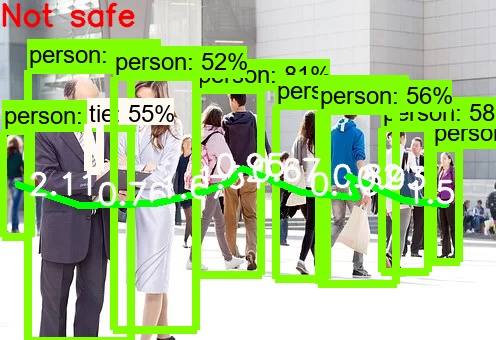

In [44]:
#facemask and social distance detector for images

path = "C:\\Users\\Sivaraman\\Desktop\\Datasets\\social_distance\\w5.webp"
image_np = cv2.imread(path)
d1 , d2 = image_np.shape[0] , image_np.shape[1]
image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
# Actual detection.
#last = time.time()
output_dict = run_inference_for_single_image(detection_model, image_np)
#print(time.time()-last)
# Visualization of the results of a detection.

# y x y x
vis_util.visualize_boxes_and_labels_on_image_array(
image_np,
output_dict['detection_boxes'],
output_dict['detection_classes'],
output_dict['detection_scores'],
category_index,
instance_masks=output_dict.get('detection_masks_reframed', None),
use_normalized_coordinates=True,
line_thickness=8)
array = []
for i in range(len(output_dict['detection_classes'])):
    if output_dict['detection_classes'][i]==1:
        array.append(output_dict['detection_boxes'][i])
array = np.array(array)
#print(array,"\n")
dist = social_dist2(array,image_np)

#image_np = cv2.imread(path)
#image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
(locs, preds) = detect_and_predict_mask(image_np, faceNet, maskNet)

# loop over the detected face locations and their corresponding
# locations
for (box, pred) in zip(locs, preds):
    # unpack the bounding box and predictions
    (startX, startY, endX, endY) = box
    (mask, withoutMask) = pred

    # determine the class label and color we'll use to draw
    # the bounding box and text
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    # include the probability in the label
    #label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    # display the label and bounding box rectangle on the output
    # frame
    cv2.putText(image_np, label, (startX, startY - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image_np, (startX, startY), (endX, endY), color, 2)


if len(dist)!=0:
    key = min(dist)
    print(key)
    if   key<0.6:
        #print(min(social_dist(output_dict['detection_boxes'])))
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_np,'Not safe',(0,25), font, 1, (250,0,0), 2, cv2.LINE_AA)
    else:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_np,'Safe',(0,25), font, 1, (0,200,100), 2, cv2.LINE_AA)
        
print("Min dist ",key)
    
display(Image.fromarray(image_np))


In [ ]:
#facemask and social distance detector from webcam

cap = cv2.VideoCapture(0)
while True:
    ret,image_np = cap.read()
    d1 , d2 = image_np.shape[0] , image_np.shape[1]
    #image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
    # Actual detection.
    #last = time.time()
    output_dict = run_inference_for_single_image(detection_model, image_np)
    #print(time.time()-last)
    # Visualization of the results of a detection.

    # y x y x
    vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8)
    array = []
    for i in range(len(output_dict['detection_classes'])):
        if output_dict['detection_classes'][i]==1:
            array.append(output_dict['detection_boxes'][i])
    array = np.array(array)
    #print(array,"\n")
    dist = social_dist2(array,image_np)

    #image_np = cv2.imread(path)
    #image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
    (locs, preds) = detect_and_predict_mask(image_np, faceNet, maskNet)

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        #label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image_np, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image_np, (startX, startY), (endX, endY), color, 2)


    if len(dist)!=0:
        key = min(dist)
        print(key)
        if   key<0.6:
            #print(min(social_dist(output_dict['detection_boxes'])))
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_np,'Not safe',(0,25), font, 1, (250,0,0), 2, cv2.LINE_AA)
        else:
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_np,'Safe',(0,25), font, 1, (0,200,100), 2, cv2.LINE_AA)

    print("Min dist ",key)

    #display(Image.fromarray(image_np))

    cv2.imshow("camera_window",image_np) 
    k = cv2.waitKey(1) 
    if k==ord('s'):
        break
cap.release()
cv2.destroyAllWindows()


In [47]:
#facemask and social distance detector from video

path = "C:\\Users\\Sivaraman\\Desktop\\Datasets\\faces1\\vid.mp4"
cap1 = cv2.VideoCapture(path) 
if cap1.isOpened()==False:
    print("error")


while (cap1.isOpened()): 


    ret1, image_np = cap1.read() 
    if ret1==True:
        d1 , d2 = image_np.shape[0] , image_np.shape[1]
    #image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
    # Actual detection.
    #last = time.time()
    output_dict = run_inference_for_single_image(detection_model, image_np)
    #print(time.time()-last)
    # Visualization of the results of a detection.

    # y x y x
    vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8)
    array = []
    for i in range(len(output_dict['detection_classes'])):
        if output_dict['detection_classes'][i]==1:
            array.append(output_dict['detection_boxes'][i])
    array = np.array(array)
    #print(array,"\n")
    dist = social_dist2(array,image_np)

    #image_np = cv2.imread(path)
    #image_np = cv2.cvtColor(image_np,cv2.COLOR_BGR2RGB)
    (locs, preds) = detect_and_predict_mask(image_np, faceNet, maskNet)

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        #label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image_np, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image_np, (startX, startY), (endX, endY), color, 2)


    if len(dist)!=0:
        key = min(dist)
        print(key)
        if   key<0.6:
            #print(min(social_dist(output_dict['detection_boxes'])))
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_np,'Not safe',(0,25), font, 1, (250,0,0), 2, cv2.LINE_AA)
        else:
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_np,'Safe',(0,25), font, 1, (0,200,100), 2, cv2.LINE_AA)

    print("Min dist ",key)

    #display(Image.fromarray(image_np))
    cv2.imshow("win",image_np)
        
    k = cv2.waitKey(1) 
    if k==ord('s'):
        break
cap1.release()
cv2.destroyAllWindows()

   


d1 2.0462558706289133 

d2 3.43274843576925 

d3 129

dist 1.6652282523478852
d1 3.43274843576925 

d2 1.9665964265747462 

d3 92

dist 1.7123971558832851
d1 1.9665964265747462 

d2 1.9862526136281602 

d3 18

dist 0.19827348321117344
d1 1.9862526136281602 

d2 3.161430903444506 

d3 57

dist 1.5330872708544117
d1 3.161430903444506 

d2 2.9021489614271747 

d3 60

dist 0.7201137996846502
d1 2.9021489614271747 

d2 2.3571342746731556 

d3 80

dist 1.0440447185499198
0.19827348321117344
Min dist  0.19827348321117344
d1 2.1447242048781394 

d2 3.4779812111345993 

d3 117

dist 1.6329464211249796
d1 3.4779812111345993 

d2 1.9709470879175175 

d3 102

dist 1.736107210907352
d1 1.9709470879175175 

d2 3.333239097713541 

d3 58

dist 1.6506314004136038
d1 3.333239097713541 

d2 3.1138506454919597 

d3 41

dist 0.6624023736744789
d1 3.1138506454919597 

d2 3.117564184287872 

d3 17

dist 0.08618049448098478
d1 3.117564184287872 

d2 2.3193410690950635 

d3 77

dist 1.2635055326955742
0.086180

0.3828345971888684
Min dist  0.3828345971888684
d1 3.40187148786627 

d2 3.018107670890979 

d3 77

dist 0.8760865452087246
d1 3.018107670890979 

d2 3.8563077390857057 

d3 124

dist 1.2947587182063522
d1 3.8563077390857057 

d2 4.825104669942204 

d3 57

dist 1.3919748065736302
d1 4.825104669942204 

d2 2.973938109206978 

d3 56

dist 1.924144776744593
d1 2.973938109206978 

d2 4.087798761790606 

d3 75

dist 1.4925552940816877
d1 4.087798761790606 

d2 4.010282304737162 

d3 18

dist 0.39374219248722764
d1 4.010282304737162 

d2 4.569279374253105 

d3 63

dist 1.0573524197527284
0.39374219248722764
Min dist  0.39374219248722764
d1 3.564535879173482 

d2 3.1108262175812644 

d3 77

dist 0.952585599281028
d1 3.1108262175812644 

d2 3.885091703169989 

d3 121

dist 1.2443998445230997
d1 3.885091703169989 

d2 4.732895811652998 

d3 57

dist 1.3021552201601965
d1 4.732895811652998 

d2 3.0517947954309275 

d3 56

dist 1.8336308333031095
d1 3.0517947954309275 

d2 4.258735970459162 

d3 

0.9253988054418478
Min dist  0.9253988054418478
d1 3.89200803031307 

d2 3.479215826719825 

d3 77

dist 0.9086167552694112
d1 3.479215826719825 

d2 4.076437537410637 

d3 114

dist 1.0929059534296612
d1 4.076437537410637 

d2 5.4599285100976225 

d3 59

dist 1.6634247641005164
d1 5.4599285100976225 

d2 3.2435691791601986 

d3 49

dist 2.105402256619538
d1 3.2435691791601986 

d2 4.464519705041157 

d3 72

dist 1.5626583287550022
d1 4.464519705041157 

d2 4.933986953361225 

d3 69

dist 0.9689863245989131
0.9086167552694112
Min dist  0.9086167552694112
d1 3.891600699590281 

d2 3.49139433648722 

d3 77

dist 0.8946578826447439
d1 3.49139433648722 

d2 4.071476249368164 

d3 114

dist 1.0771090137100492
d1 4.071476249368164 

d2 5.497810303044803 

d3 59

dist 1.6889843420827
d1 5.497810303044803 

d2 3.2486330924365934 

d3 49

dist 2.120932441527257
d1 3.2486330924365934 

d2 4.4795674000148225 

d3 72

dist 1.5690342940231947
d1 4.4795674000148225 

d2 4.9504035243615405 

d3 69

d

0.9854545463516378
Min dist  0.9854545463516378
d1 3.964084517527972 

d2 3.4924787914351967 

d3 77

dist 0.9711907397297371
d1 3.4924787914351967 

d2 4.120772235291396 

d3 113

dist 1.1209758647478087
d1 4.120772235291396 

d2 3.2868537445941772 

d3 107

dist 1.2914476307160443
d1 3.2868537445941772 

d2 4.5648703635983665 

d3 73

dist 1.5987599065146116
d1 4.5648703635983665 

d2 5.068935051644504 

d3 68

dist 1.0040564609120903
0.9711907397297371
Min dist  0.9711907397297371
d1 3.9813793386416787 

d2 3.4981236637300395 

d3 76

dist 0.9831130914435466
d1 3.4981236637300395 

d2 4.119637152400545 

d3 113

dist 1.1149111977987425
d1 4.119637152400545 

d2 3.293919912663574 

d3 107

dist 1.2850815075176527
d1 3.293919912663574 

d2 4.540120285644935 

d3 73

dist 1.5787339062161
d1 4.540120285644935 

d2 5.079215346624672 

d3 68

dist 1.0383593417311312
0.9831130914435466
Min dist  0.9831130914435466
d1 3.9295424193610753 

d2 3.500756399399094 

d3 76

dist 0.926051856354379

0.7999511974283078
Min dist  0.7999511974283078
d1 3.9787490062068596 

d2 3.6680904247657793 

d3 76

dist 0.7882367433853393
d1 3.6680904247657793 

d2 4.154178544149137 

d3 110

dist 0.9859899798243862
d1 4.154178544149137 

d2 3.266081651909033 

d3 108

dist 1.3327392040356063
d1 3.266081651909033 

d2 4.531641311939239 

d3 74

dist 1.5909491886161975
d1 4.531641311939239 

d2 4.972914552982894 

d3 67

dist 0.939439451308499
0.7882367433853393
Min dist  0.7882367433853393
d1 3.9975418618722216 

d2 3.6804776060642013 

d3 75

dist 0.7963218647980519
d1 3.6804776060642013 

d2 4.149775491780169 

d3 110

dist 0.968811526032347
d1 4.149775491780169 

d2 3.263756149356608 

d3 108

dist 1.331179434315941
d1 3.263756149356608 

d2 4.529594931570099 

d3 74

dist 1.5911246227497295
d1 4.529594931570099 

d2 4.961222819650563 

d3 67

dist 0.9291155884757393
0.7963218647980519
Min dist  0.7963218647980519
d1 4.01611251277699 

d2 3.6823107374081996 

d3 76

dist 0.8170701019359948
d1

0.8192103564029831
Min dist  0.8192103564029831
d1 4.021179496134591 

d2 3.7660126348340395 

d3 74

dist 0.7143764576947711
d1 3.7660126348340395 

d2 4.1639619992047 

d3 110

dist 0.892131565574992
d1 4.1639619992047 

d2 3.2514145456964982 

d3 107

dist 1.3509607353614321
d1 3.2514145456964982 

d2 4.6774400997195835 

d3 74

dist 1.6888016783365654
d1 4.6774400997195835 

d2 5.060732850856823 

d3 64

dist 0.8755486867093317
0.7143764576947711
Min dist  0.7143764576947711
d1 4.020643249176695 

d2 3.7526519062548385 

d3 74

dist 0.7321083844297694
d1 3.7526519062548385 

d2 4.163850819408209 

d3 110

dist 0.9068615262877762
d1 4.163850819408209 

d2 3.2488746074973403 

d3 107

dist 1.3527573416150547
d1 3.2488746074973403 

d2 4.656576812826515 

d3 74

dist 1.6779166878503113
d1 4.656576812826515 

d2 5.06954194533229 

d3 64

dist 0.9088070562718453
0.7321083844297694
Min dist  0.7321083844297694
d1 4.028654333960191 

d2 3.742288532071976 

d3 74

dist 0.7567903305888871
d